In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22298 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleus

In [1]:
import os
os.chdir('drive/keras/alphabets_digits')
!ls

 alphabets_digits1.h5   alphabets.h5		    dip_assignment.ipynb
 alphabets_digits2.h5  'A_Z Handwritten Data.csv'   images
 alphabets_digits.h5   'A_Z Handwritten Data.zip'


In [2]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import glob
from scipy.misc import imresize

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [3]:
data = pd.read_csv('A_Z Handwritten Data.csv')
print(data.shape)
data = np.array(data)
X = data[:,1:]
y = data[:,0]
print(X.shape,y.shape)

(372450, 785)
(372450, 784) (372450,)


In [0]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
X = np.reshape(X,(X.shape[0],28,28))
X = np.concatenate((X,x_train,x_test))
del x_train,x_test
y_train = y_train + 26
y_test = y_test + 26
y = np.concatenate((y,y_train,y_test))
del y_train,y_test
print(X.shape,y.shape)

(442450, 28, 28) (442450,)


In [0]:
batch_size = 2048
num_classes = 36
epochs = 12
# input image dimensions
img_rows, img_cols = 28, 28
input_shape = (28,28,1)

In [7]:
X = np.expand_dims(X,axis = 3)
X = X.astype('float32')
# convert class vectors to binary class matrices
y = keras.utils.to_categorical(y, num_classes)
X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
del X,y

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (398205, 28, 28, 1)
398205 train samples
44245 test samples


14
17
12
18
27


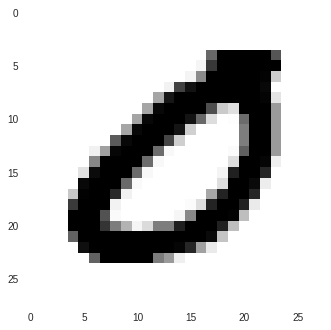

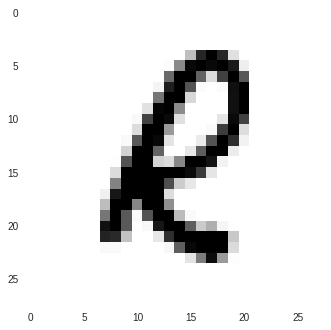

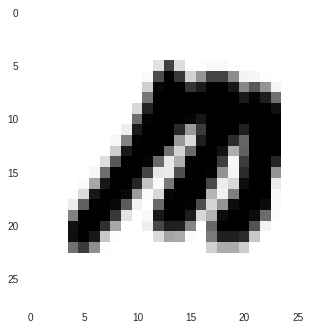

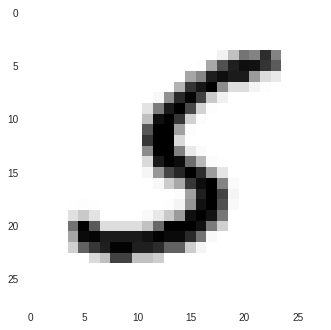

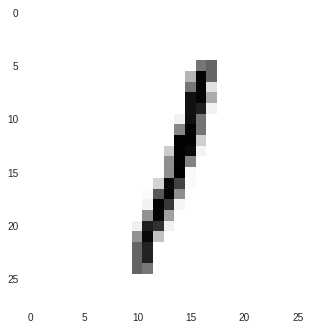

In [8]:
for i in range(5):
  a = np.random.randint(0,len(X_test))
  plt.figure()
  plt.grid(False)
  plt.imshow(np.reshape(X_test[a,:,:,:],(28,28)))
  y = y_test[a,:]
  print(np.argmax(y))


In [9]:
#building model
model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.adam(),
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          18496     
__________

In [10]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 398205 samples, validate on 44245 samples
Epoch 1/12
398205/398205 [==============================] - 43s 109us/step - loss: 0.4431 - acc: 0.8833 - val_loss: 0.1089 - val_acc: 0.9690
Epoch 2/12
398205/398205 [==============================] - 40s 101us/step - loss: 0.1397 - acc: 0.9604 - val_loss: 0.0781 - val_acc: 0.9778
Epoch 3/12
398205/398205 [==============================] - 40s 101us/step - loss: 0.1038 - acc: 0.9706 - val_loss: 0.0691 - val_acc: 0.9807
Epoch 4/12
398205/398205 [==============================] - 41s 102us/step - loss: 0.0852 - acc: 0.9755 - val_loss: 0.0638 - val_acc: 0.9822
Epoch 5/12
398205/398205 [==============================] - 40s 101us/step - loss: 0.0719 - acc: 0.9792 - val_loss: 0.0580 - val_acc: 0.9834
Epoch 6/12
398205/398205 [==============================] - 40s 100us/step - loss: 0.0631 - acc: 0.9814 - val_loss: 0.0505 - val_acc: 0.9858
Epoch 7/12
398205/398205 [==============================] - 40s 100us/step - loss: 0.0568 - acc: 0.9829

In [0]:
from keras.models import load_model
model.save('alphabets_digits2.h5')  


In [12]:
from keras.models import load_model
model = load_model('alphabets.h5')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [0]:
import numpy as np
from scipy.misc import imresize
from sklearn import preprocessing

def preprocess_image(img):  
  img = imresize(img,(28,28))
  img = np.expand_dims(img,axis=0)
  result = np.expand_dims(img,axis=3)
  return result

def encoding(prediction):
  label_encoder = preprocessing.LabelEncoder()
  label_encoder.fit(['A','B','C','D','E','F','G','H','I','J','K','L','M',
        'N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
  result = label_encoder.inverse_transform([prediction])
  result = result[0]
  return result



image = None#load image
pre_image = preprocess_image(image)
y = model.predict(pre_image)
print(y)